# Lab 2: Fully Connected Neural Networks (FCNN)
## Hardware For Machine Learning Course

This lab focuses on the architecture, implementation, and hardware implications of Fully Connected Neural Networks (FCNNs). You will implement FCNNs of varying depths and widths, experiment with different activation functions and regularization techniques, and analyze how architectural choices impact performance, computational requirements, and hardware efficiency.

**Note:** This version uses CIFAR-10 dataset for most experiments, with comparison between CIFAR-10 and Fashion MNIST.

## PART 1: ENVIRONMENT SETUP

In this section, we'll set up our environment and import necessary libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import psutil
import os

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# If psutil is not installed, uncomment this line:
# !pip install psutil

# Mount Google Drive (uncomment when running in Colab)
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir -p "/content/drive/My Drive/ML_Hardware_Course/Lab2"

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check for accelerator (GPU or TPU)
accelerator_found = False
using_tpu = False
strategy = None

# Check for TPU first (specifically for Colab)
try:
    # For Colab TPU, we need to use the following approach
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # Simplified TPU initialization for Colab
    print(f"TPU detected, initializing...")

    # Create TPU strategy
    strategy = tf.distribute.TPUStrategy(tpu)
    using_tpu = True
    accelerator_found = True
    print(f"TPU initialized with {strategy.num_replicas_in_sync} replicas")
    print(f"TPU type: {tpu.get_master()}")  # This will show the TPU type
except (ValueError, AttributeError, ImportError, Exception) as e:
    print(f"TPU not available: {e}")

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    accelerator_found = True
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"GPU detected: {gpus[0].name}")
else:
    print("No accelerator detected!")

if not accelerator_found:
    raise RuntimeError("No accelerator (GPU or TPU) detected! Please choose a GPU or TPU runtime in Colab.")

## PART 2: DATASET PREPARATION

In this section, we'll load and prepare the CIFAR-10 and Fashion MNIST datasets.

In [2]:
def load_and_prepare_cifar10():
    """
    Load and prepare the CIFAR-10 dataset for training FCNNs.

    Returns:
        tuple: Training, validation, and test data along with test labels
    """
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Print original data shapes
    print("Original CIFAR-10 shapes:")
    print(f"  X_train: {x_train.shape}, y_train: {y_train.shape}")
    print(f"  X_test: {x_test.shape}, y_test: {y_test.shape}")

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Reshape data (flatten images) - CIFAR-10 has 32x32x3 = 3072 features
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # Flatten y_train if needed (CIFAR-10 returns shape (n, 1))
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # One-hot encode labels
    y_train_encoded = to_categorical(y_train, 10)
    y_test_encoded = to_categorical(y_test, 10)

    # Create validation set (10% of training data)
    val_size = 5000
    x_val = x_train_flat[-val_size:]
    y_val = y_train_encoded[-val_size:]
    x_train_final = x_train_flat[:-val_size]
    y_train_final = y_train_encoded[:-val_size]

    print("\nProcessed CIFAR-10 dataset:")
    print(f"  Training set: {x_train_final.shape}")
    print(f"  Validation set: {x_val.shape}")
    print(f"  Test set: {x_test_flat.shape}")
    print(f"  Input dimension: {x_train_final.shape[1]} (32x32x3)")

    return (x_train_final, y_train_final), (x_val, y_val), (x_test_flat, y_test_encoded), y_test

def load_and_prepare_fashion_mnist():
    """
    Load and prepare the Fashion MNIST dataset for training FCNNs.

    Returns:
        tuple: Training, validation, and test data along with test labels
    """
    # Load Fashion MNIST dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Print original data shapes
    print("\nOriginal Fashion MNIST shapes:")
    print(f"  X_train: {x_train.shape}, y_train: {y_train.shape}")
    print(f"  X_test: {x_test.shape}, y_test: {y_test.shape}")

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Reshape data (flatten images)
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # One-hot encode labels
    y_train_encoded = to_categorical(y_train, 10)
    y_test_encoded = to_categorical(y_test, 10)

    # Create validation set (10% of training data)
    val_size = 6000
    x_val = x_train_flat[-val_size:]
    y_val = y_train_encoded[-val_size:]
    x_train_final = x_train_flat[:-val_size]
    y_train_final = y_train_encoded[:-val_size]

    print("\nProcessed Fashion MNIST dataset:")
    print(f"  Training set: {x_train_final.shape}")
    print(f"  Validation set: {x_val.shape}")
    print(f"  Test set: {x_test_flat.shape}")

    return (x_train_final, y_train_final), (x_val, y_val), (x_test_flat, y_test_encoded), y_test

# Define class names for CIFAR-10
cifar10_class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                        'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Define class names for Fashion MNIST
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load both datasets
print("Loading CIFAR-10 dataset...")
cifar_train, cifar_val, cifar_test, cifar_y_test = load_and_prepare_cifar10()

print("\nLoading Fashion MNIST dataset...")
fashion_train, fashion_val, fashion_test, fashion_y_test = load_and_prepare_fashion_mnist()

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Original CIFAR-10 shapes:
  X_train: (50000, 32, 32, 3), y_train: (50000, 1)
  X_test: (10000, 32, 32, 3), y_test: (10000, 1)

Processed CIFAR-10 dataset:
  Training set: (45000, 3072)
  Validation set: (5000, 3072)
  Test set: (10000, 3072)
  Input dimension: 3072 (32x32x3)

Loading Fashion MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Original Fashion MNIST shapes:
  X_train: (60000, 28, 28), y_train: (60000,)
  X_test: (10000, 28, 28), y_test: (10000,)

Processed Fashion MNIST dataset:
  Training set: (54000, 784)
  Validation set: (6000, 784)
  Test set: (10000, 784)



Displaying CIFAR-10 samples:


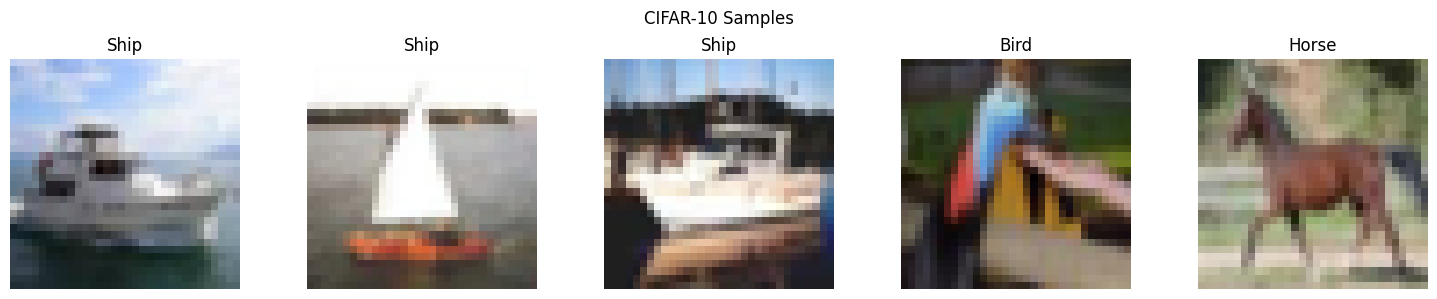


Displaying Fashion MNIST samples:


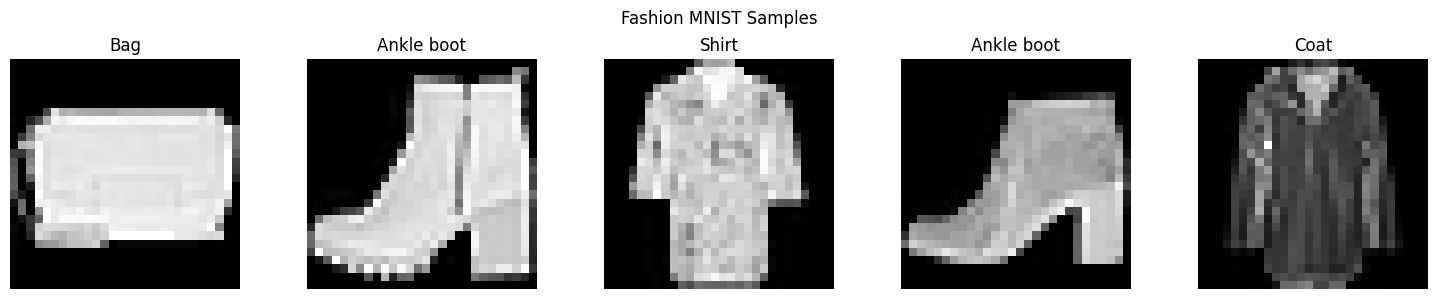

In [ ]:
# Display sample images from both datasets
def display_samples_cifar10(dataset_name, x_data, y_data, class_names, num_samples=5):
    """
    Display sample images from CIFAR-10 dataset.
    """
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(x_data))
        # Reshape back to original CIFAR-10 format (32, 32, 3)
        img = x_data[idx].reshape(32, 32, 3)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        class_idx = np.argmax(y_data[idx])
        plt.title(f"{class_names[class_idx]}")
        plt.axis('off')
    plt.suptitle(f"{dataset_name} Samples")
    plt.tight_layout()
    plt.show()

def display_samples_fashion(dataset_name, x_data, y_data, class_names, num_samples=5):
    """
    Display sample images from Fashion MNIST dataset.
    """
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(x_data))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        class_idx = np.argmax(y_data[idx])
        plt.title(f"{class_names[class_idx]}")
        plt.axis('off')
    plt.suptitle(f"{dataset_name} Samples")
    plt.tight_layout()
    plt.show()

# Display sample images
print("\nDisplaying CIFAR-10 samples:") # A To Do task is here
display_samples_cifar10("CIFAR-10", cifar_train[0], cifar_train[1], cifar10_class_names) 

print("\nDisplaying Fashion MNIST samples:") # A To Do task is here
display_samples_fashion("Fashion MNIST", fashion_train[0], fashion_train[1], fashion_class_names)

## PART 3: FULLY CONNECTED NEURAL NETWORK IMPLEMENTATION

In this section, we'll implement functions to create and train Fully Connected Neural Networks with various architectures.

In [ ]:
def create_fcnn(input_dim, hidden_layers, hidden_units, activation='relu', dropout_rate=0.0):
    """
    Create a Fully Connected Neural Network with specified architecture.

    Args:
        input_dim: Input dimension (e.g., 3072 for CIFAR-10)
        hidden_layers: Number of hidden layers
        hidden_units: List or int specifying neurons in each hidden layer
        activation: Activation function to use
        dropout_rate: Dropout rate (0 = no dropout)

    Returns:
        model: Compiled Keras model
    """
    model = Sequential(name=f"FCNN_L{hidden_layers}_U{hidden_units if isinstance(hidden_units, int) else '-'.join(map(str, hidden_units))}")

    # Convert hidden_units to list if it's an integer
    if isinstance(hidden_units, int):
        hidden_units = [hidden_units] * hidden_layers

    # Ensure we have enough hidden_units specified
    if len(hidden_units) < hidden_layers:
        hidden_units = hidden_units + [hidden_units[-1]] * (hidden_layers - len(hidden_units))

    # Add input layer
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(input_dim,),
                   name=f'dense_1_{hidden_units[0]}'))

    # Add dropout if specified
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, name=f'dropout_1_{dropout_rate}'))

    # Add additional hidden layers
    for i in range(1, hidden_layers):
        model.add(Dense(hidden_units[i], activation=activation,
                       name=f'dense_{i+1}_{hidden_units[i]}'))

        # Add dropout if specified
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate, name=f'dropout_{i+1}_{dropout_rate}'))

    # Add output layer
    model.add(Dense(10, activation='softmax', name='output'))

    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def train_and_evaluate_model(model, train_data, val_data, test_data, model_name,
                            batch_size=128, epochs=30, patience=5, verbose=1):
    """
    Train and evaluate a model, and calculate performance metrics.
    """
    x_train, y_train = train_data
    x_val, y_val = val_data
    x_test, y_test = test_data

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        verbose=(1 if verbose > 0 else 0)
    )

    print(f"\nTraining {model_name}...")

    # Record start time
    start_time = time.time() # A To Do task is here

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=verbose
    )

    # Calculate training time
    training_time = time.time() - start_time # A To Do task is here

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0) # A To Do task is here

    # Measure inference time (average over 1000 samples)
    inference_samples = min(1000, len(x_test))
    start_time = time.time()
    _ = model.predict(x_test[:inference_samples], verbose=0)
    inference_time = (time.time() - start_time) / inference_samples  # per sample

    # Count parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params # A To Do task is here

    # Calculate train-validation gap (for overfitting analysis)
    train_acc = max(history.history['accuracy'])
    val_acc = max(history.history['val_accuracy'])
    train_val_gap = train_acc - val_acc

    # Calculate efficiency metrics
    params_per_second = total_params / training_time # A To Do task is here
    accuracy_per_million_params = test_accuracy * 100 / (total_params / 1e6) # A To Do task is here

    # Store results
    results = {
        'model_name': model_name,
        'history': history,
        'training_time': training_time,
        'test_accuracy': test_accuracy * 100,  # convert to percentage
        'test_loss': test_loss,
        'inference_time': inference_time * 1000,  # convert to milliseconds
        'total_params': total_params,
        'trainable_params': trainable_params,
        'params_per_second': params_per_second,
        'accuracy_per_million_params': accuracy_per_million_params,
        'epochs_trained': len(history.history['accuracy']),
        'train_val_gap': train_val_gap,
        'batch_size': batch_size
    }

    print(f"\n--- {model_name} Results ---")
    print(f"Test Accuracy: {results['test_accuracy']:.2f}%")
    print(f"Training Time: {results['training_time']:.2f} seconds")
    print(f"Inference Time: {results['inference_time']:.4f} ms")
    print(f"Total Parameters: {results['total_params']:,}")
    print(f"Epochs Trained: {results['epochs_trained']}")
    print(f"Train-Val Gap: {results['train_val_gap']:.4f}")

    return results

## PART 4: VISUALIZATION AND ANALYSIS FUNCTIONS

Here we implement functions for visualizing and analyzing model performance.

In [5]:
def plot_training_history(histories, labels=None):
    """
    Plot training history for multiple models.
    """
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, hist in enumerate(histories):
        history = hist['history'] if isinstance(hist, dict) else hist
        label = labels[i] if labels else f"Model {i+1}"
        plt.plot(history.history['accuracy'], label=f"{label} - Train")
        plt.plot(history.history['val_accuracy'], label=f"{label} - Val")

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    for i, hist in enumerate(histories):
        history = hist['history'] if isinstance(hist, dict) else hist
        label = labels[i] if labels else f"Model {i+1}"
        plt.plot(history.history['loss'], label=f"{label} - Train")
        plt.plot(history.history['val_loss'], label=f"{label} - Val")

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, x_test, y_test_true, class_names, title):
    """
    Plot confusion matrix for model predictions.
    """
    # Generate predictions
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test_true, y_pred_classes)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Find most confused pairs
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, 0)  # Ignore correct classifications
    max_confusion = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)
    print(f"Most confused pair: {class_names[max_confusion[0]]} mistaken for {class_names[max_confusion[1]]} ({cm_copy[max_confusion]} times)")

    return cm, max_confusion

def profile_memory_usage(model, x_input, batch_size=32):
    """
    Profile memory usage during model inference.
    """
    # Record baseline memory usage
    baseline_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB

    # Warm-up run
    _ = model.predict(x_input[:batch_size], verbose=0)

    # Record memory usage during inference
    peak_memory = baseline_memory

    for i in range(0, min(1000, len(x_input)), batch_size):
        batch = x_input[i:i+batch_size]
        _ = model.predict(batch, verbose=0)
        current_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # MB
        peak_memory = max(peak_memory, current_memory)

    memory_results = {
        'baseline_memory_mb': baseline_memory,
        'peak_memory_mb': peak_memory,
        'memory_increase_mb': peak_memory - baseline_memory
    }

    print(f"Memory profiling results:")
    print(f"  Baseline Memory: {memory_results['baseline_memory_mb']:.2f} MB")
    print(f"  Peak Memory: {memory_results['peak_memory_mb']:.2f} MB")
    print(f"  Memory Increase: {memory_results['memory_increase_mb']:.2f} MB")

    return memory_results

def is_pareto_efficient(costs):
    """
    Find the Pareto-efficient points.
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Keep any point with a lower cost in at least one dimension
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
    return is_efficient

def plot_metric_comparison(results_df, x_metric, y_metric, title, annotate=True):
    """
    Plot a comparison of two metrics across models.
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(results_df[x_metric], results_df[y_metric], s=100, alpha=0.7)

    if annotate:
        for i, row in results_df.iterrows():
            model_name = row['Model'].replace('FCNN_', '')
            plt.annotate(model_name,
                        (row[x_metric], row[y_metric]),
                        xytext=(5, 5), textcoords='offset points')

    plt.title(title)
    plt.xlabel(x_metric)
    plt.ylabel(y_metric)
    plt.grid(True)
    plt.show()

## PART 5: EXPERIMENT - NETWORK DEPTH VARIATION (CIFAR-10)

In this experiment, we'll examine how varying the number of hidden layers affects model performance and computational requirements on CIFAR-10.


EXPERIMENT 1: VARYING NETWORK DEPTH (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training FCNN_Depth_1...
Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2024 - loss: 2.3218 - val_accuracy: 0.3262 - val_loss: 1.9008
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2862 - loss: 1.9320 - val_accuracy: 0.3472 - val_loss: 1.8421
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3010 - loss: 1.8951 - val_accuracy: 0.3556 - val_loss: 1.7994
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3118 - loss: 1.8728 - val_accuracy: 0.3808 - val_loss: 1.7547
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3213 - loss: 1.8481 - val_accuracy: 0.3866 - val_loss: 1.7489
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3283 - loss: 1.8371 - val_accuracy: 0.3908 - val_loss: 1.7396
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3346 - loss: 1.8304 - val_accuracy: 0.3818 - val_loss: 1.7308
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3355 - loss

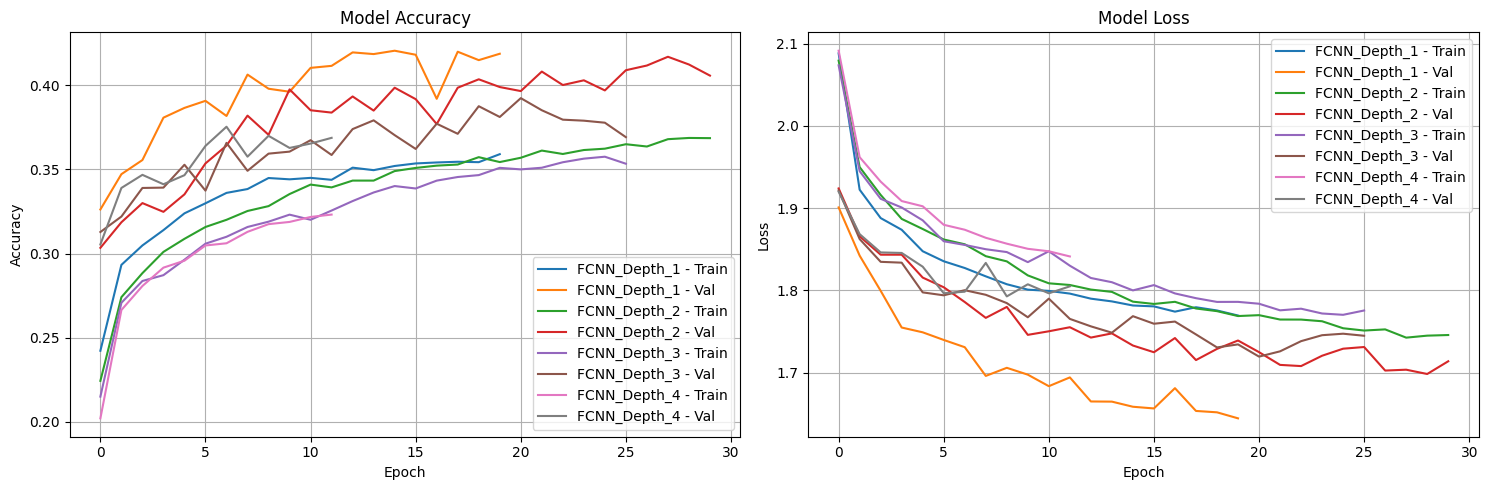


Depth Experiment Results (CIFAR-10):
       Model  Depth  Accuracy (%)  Training Time (s)  Inference Time (ms)  Parameters  Params/Second  Accuracy/Million Params  Train-Val Gap
FCNN_Depth_1      1     41.880000          37.771215             0.523536    789258.0   20895.753441                53.062496      -0.061511
FCNN_Depth_2      2     41.729999          58.471544             0.510711    855050.0   14623.352448                48.804162      -0.048267
FCNN_Depth_3      3     39.199999          49.565199             0.768436    920842.0   18578.397981                42.569734      -0.034822
FCNN_Depth_4      4     37.380001          27.735192             0.569664    986634.0   35573.361627                37.886390      -0.052222


In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 1: VARYING NETWORK DEPTH (CIFAR-10)")
print("="*50)

# Experiment with different network depths
depth_results = []
depth_histories = []
depth_models = []
depth_names = []

# Create models with different depths (1, 2, 3, 4 hidden layers)
for num_layers in [1, 2, 3, 4]: # A To Do task is here
    model_name = f"FCNN_Depth_{num_layers}"

    model = create_fcnn( # A To Do task is here
        input_dim=3072,  # CIFAR-10 flattened dimension (32x32x3)
        hidden_layers=num_layers,
        hidden_units=256,  # Increased for more complex CIFAR-10 data
        activation='relu',
        dropout_rate=0.3  # Slightly higher dropout for CIFAR-10
    )

    result = train_and_evaluate_model(
        model=model,
        train_data=cifar_train,
        val_data=cifar_val,
        test_data=cifar_test,
        model_name=model_name,
        epochs=30,
        patience=5,
        verbose=1
    )

    depth_results.append(result)
    depth_histories.append(result['history'])
    depth_models.append(model)
    depth_names.append(model_name)

# Plot training history for different depths
print("\nTraining history comparison for different network depths:")
plot_training_history(depth_histories, depth_names)

# Create results table
depth_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Depth': i+1,
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Inference Time (ms)': result['inference_time'],
        'Parameters': result['total_params'],
        'Params/Second': result['params_per_second'],
        'Accuracy/Million Params': result['accuracy_per_million_params'],
        'Train-Val Gap': result['train_val_gap']
    }
    for i, result in enumerate(depth_results)
])

print("\nDepth Experiment Results (CIFAR-10):")
print(depth_df.to_string(index=False))

## PART 6: EXPERIMENT - NETWORK WIDTH VARIATION (CIFAR-10)

In this experiment, we'll examine how varying the number of neurons in each layer affects model performance and computational requirements on CIFAR-10.


EXPERIMENT 2: VARYING NETWORK WIDTH (CIFAR-10)

Training FCNN_Width_128...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.1842 - loss: 2.1761 - val_accuracy: 0.3164 - val_loss: 1.8930
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2551 - loss: 1.9826 - val_accuracy: 0.3272 - val_loss: 1.8765
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2772 - loss: 1.9491 - val_accuracy: 0.3422 - val_loss: 1.8477
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2774 - loss: 1.9270 - val_accuracy: 0.3438 - val_loss: 1.8419
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2925 - loss: 1.9064 - val_accuracy: 0.3576 - val_loss: 1.8223
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3036 - loss: 1.8913 - val_accuracy: 0.3674 - val_loss: 1.7932
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3095 - loss: 1.8808 - val_accuracy: 0.3474 - val_loss: 1.8174
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3119 - loss: 1.8716 - val_accuracy: 0

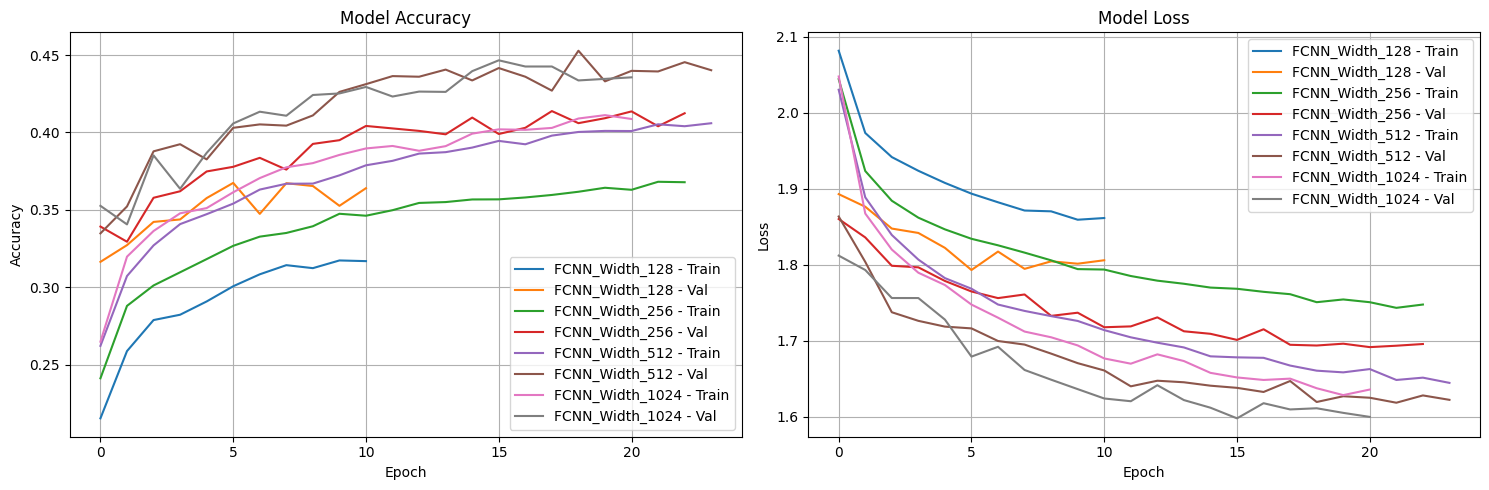


Width Experiment Results (CIFAR-10):
          Model  Width  Accuracy (%)  Training Time (s)  Inference Time (ms)  Parameters  Params/Second  Accuracy/Million Params  Train-Val Gap
 FCNN_Width_128    128     37.029999          25.757091             0.532233    411146.0   15962.439504                90.065328      -0.050089
 FCNN_Width_256    256     40.840000          42.438722             0.503616    855050.0   20147.873494                47.763289      -0.045667
 FCNN_Width_512    512     44.340000          45.667855             0.508225   1841162.0   40316.367139                24.082617      -0.046844
FCNN_Width_1024   1024     43.959999          46.943559             0.516041   4206602.0   89609.779340                10.450240      -0.035422


In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 2: VARYING NETWORK WIDTH (CIFAR-10)")
print("="*50)

# Experiment with different network widths
width_results = []
width_histories = []
width_models = []
width_names = []

# Create models with different widths (128, 256, 512, 1024 neurons)
for width in [128, 256, 512, 1024]: # A To Do task is here
    model_name = f"FCNN_Width_{width}"

    model = create_fcnn( # A To Do task is here
        input_dim=3072,
        hidden_layers=2,
        hidden_units=width,
        activation='relu',
        dropout_rate=0.3
    )

    result = train_and_evaluate_model(
        model=model,
        train_data=cifar_train,
        val_data=cifar_val,
        test_data=cifar_test,
        model_name=model_name,
        epochs=30,
        patience=5,
        verbose=1
    )

    width_results.append(result)
    width_histories.append(result['history'])
    width_models.append(model)
    width_names.append(model_name)

# Plot training history for different widths
print("\nTraining history comparison for different network widths:")
plot_training_history(width_histories, width_names)

# Create results table
width_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Width': [128, 256, 512, 1024][i],
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Inference Time (ms)': result['inference_time'],
        'Parameters': result['total_params'],
        'Params/Second': result['params_per_second'],
        'Accuracy/Million Params': result['accuracy_per_million_params'],
        'Train-Val Gap': result['train_val_gap']
    }
    for i, result in enumerate(width_results)
])

print("\nWidth Experiment Results (CIFAR-10):")
print(width_df.to_string(index=False))

## PART 7: EXPERIMENT - ACTIVATION FUNCTIONS (CIFAR-10)

In this experiment, we'll examine how different activation functions affect model performance and training dynamics on CIFAR-10.


EXPERIMENT 3: VARYING ACTIVATION FUNCTIONS (CIFAR-10)

Training FCNN_Activation_relu...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1969 - loss: 2.1886 - val_accuracy: 0.3082 - val_loss: 1.8961
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2781 - loss: 1.9430 - val_accuracy: 0.3352 - val_loss: 1.8493
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2962 - loss: 1.9005 - val_accuracy: 0.3524 - val_loss: 1.8106
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3173 - loss: 1.8549 - val_accuracy: 0.3698 - val_loss: 1.7901
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3218 - loss: 1.8407 - val_accuracy: 0.3858 - val_loss: 1.7559
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3299 - loss: 1.8212 - val_accuracy: 0.3864 - val_loss: 1.7562
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3392 - loss: 1.8105 - val_accuracy: 0.3790 - val_loss: 1.7545
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3381 - loss: 1.8037 - val_accuracy: 0

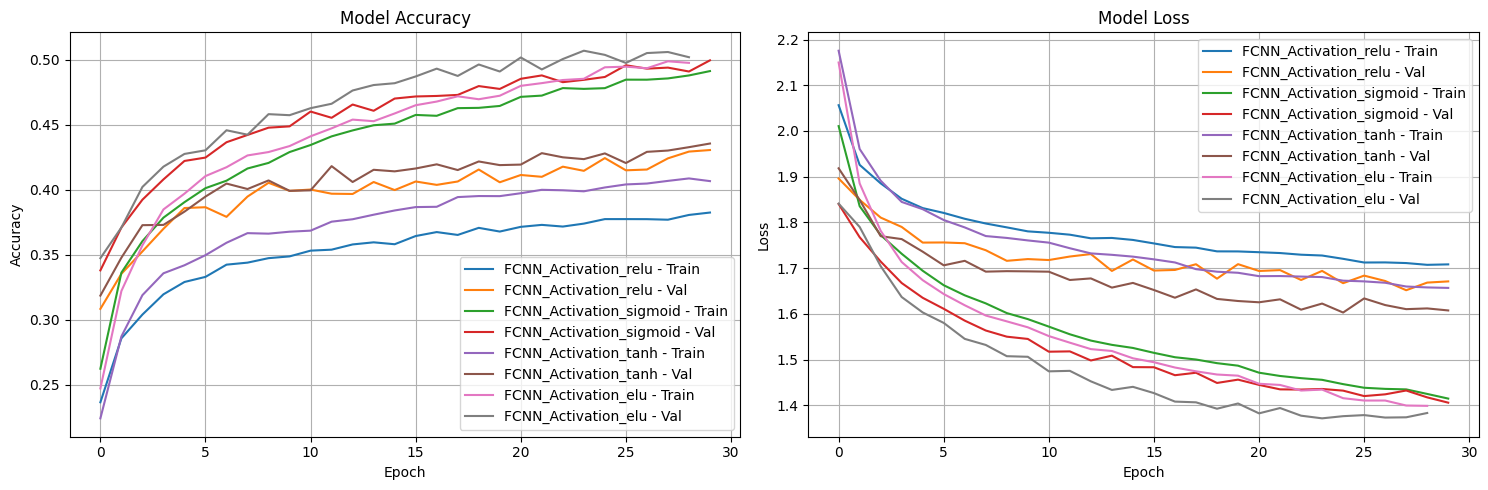


Activation Function Experiment Results (CIFAR-10):
                  Model Activation  Accuracy (%)  Training Time (s)  Epochs  Inference Time (ms)  Parameters  Params/Second  Train-Val Gap
   FCNN_Activation_relu       relu     43.489999          50.195608      30             0.526489    855050.0   17034.358977      -0.048089
FCNN_Activation_sigmoid    sigmoid     49.550000          50.204809      30             0.655081    855050.0   17031.237085      -0.008267
   FCNN_Activation_tanh       tanh     43.540001          54.063770      30             0.676318    855050.0   15815.582282      -0.026844
    FCNN_Activation_elu        elu     50.120002          53.667070      29             0.513820    855050.0   15932.489052      -0.008133


In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 3: VARYING ACTIVATION FUNCTIONS (CIFAR-10)")
print("="*50)

# Experiment with different activation functions
activation_results = []
activation_histories = []
activation_models = []
activation_names = []

# Create models with different activation functions
for activation in ['relu', 'sigmoid', 'tanh', 'elu']: # A To Do task is here
    model_name = f"FCNN_Activation_{activation}"

    model = create_fcnn( # A To Do task is here
        input_dim=3072,
        hidden_layers=2,
        hidden_units=256,
        activation=activation,
        dropout_rate=0.3
    )

    result = train_and_evaluate_model(
        model=model,
        train_data=cifar_train,
        val_data=cifar_val,
        test_data=cifar_test,
        model_name=model_name,
        epochs=30,
        patience=5,
        verbose=1
    )

    activation_results.append(result)
    activation_histories.append(result['history'])
    activation_models.append(model)
    activation_names.append(model_name)

# Plot training history for different activation functions
print("\nTraining history comparison for different activation functions:")
plot_training_history(activation_histories, activation_names)

# Create results table
activation_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Activation': ['relu', 'sigmoid', 'tanh', 'elu'][i],
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Epochs': result['epochs_trained'],
        'Inference Time (ms)': result['inference_time'],
        'Parameters': result['total_params'],
        'Params/Second': result['params_per_second'],
        'Train-Val Gap': result['train_val_gap']
    }
    for i, result in enumerate(activation_results)
])

print("\nActivation Function Experiment Results (CIFAR-10):")
print(activation_df.to_string(index=False))

## PART 8: EXPERIMENT - DROPOUT REGULARIZATION (CIFAR-10)

In this experiment, we'll examine how dropout regularization affects model performance and overfitting on CIFAR-10.


EXPERIMENT 4: VARYING DROPOUT REGULARIZATION (CIFAR-10)

Training FCNN_Dropout_0.0...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2642 - loss: 2.0495 - val_accuracy: 0.3630 - val_loss: 1.7967
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3804 - loss: 1.7230 - val_accuracy: 0.3914 - val_loss: 1.7132
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4170 - loss: 1.6324 - val_accuracy: 0.4154 - val_loss: 1.6716
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4379 - loss: 1.5695 - val_accuracy: 0.4144 - val_loss: 1.6602
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4571 - loss: 1.5245 - val_accuracy: 0.4318 - val_loss: 1.6214
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4706 - loss: 1.4931 - val_accuracy: 0.4426 - val_loss: 1.5943
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4830 - loss: 1.4600 - val_accuracy: 0.4520 - val_loss: 1.5554
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4924 - loss: 1.4315 - val_accuracy: 0.

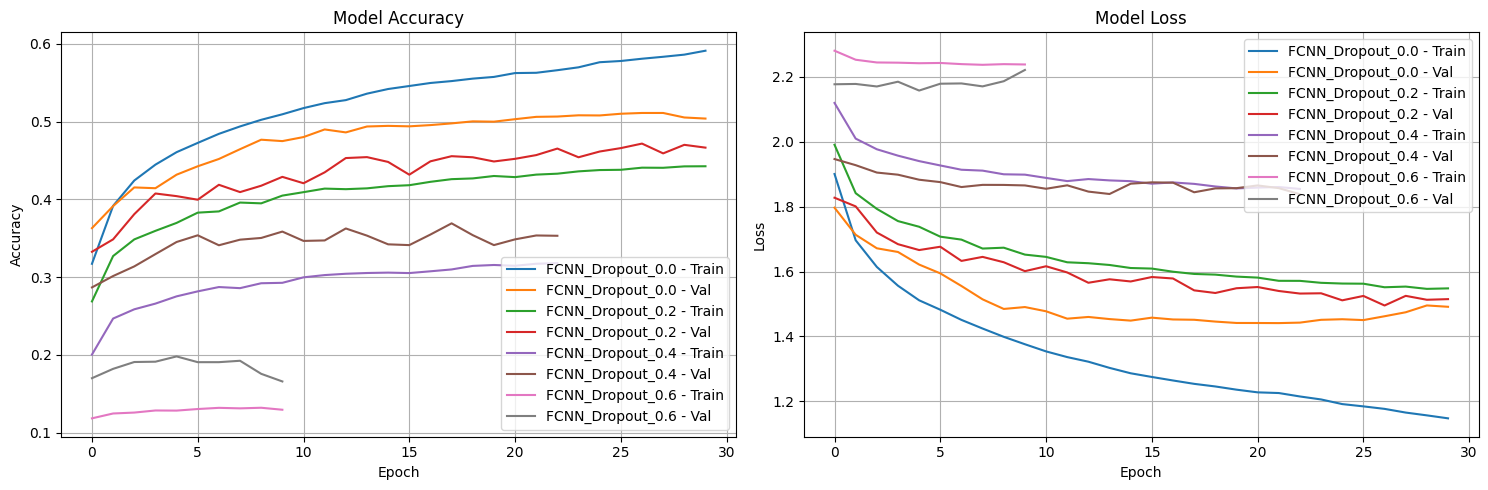


Dropout Experiment Results (CIFAR-10):
           Model  Dropout Rate  Accuracy (%)  Training Time (s)  Epochs  Train-Val Gap  Parameters
FCNN_Dropout_0.0           0.0     49.910000          52.093469      30       0.080089    855050.0
FCNN_Dropout_0.2           0.2     46.529999          53.268751      30      -0.029156    855050.0
FCNN_Dropout_0.4           0.4     36.980000          41.472922      23      -0.051200    855050.0
FCNN_Dropout_0.6           0.6     19.069999          20.629152      10      -0.066044    855050.0


In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 4: VARYING DROPOUT REGULARIZATION (CIFAR-10)")
print("="*50)

# Experiment with different dropout rates
dropout_results = []
dropout_histories = []
dropout_models = []
dropout_names = []

# Create models with different dropout rates
for dropout_rate in [0.0, 0.2, 0.4, 0.6]: # A To Do task is here
    model_name = f"FCNN_Dropout_{dropout_rate}"

    model = create_fcnn( # A To Do task is here
        input_dim=3072,
        hidden_layers=2,
        hidden_units=256,
        activation='relu',
        dropout_rate=dropout_rate
    )

    result = train_and_evaluate_model(
        model=model,
        train_data=cifar_train,
        val_data=cifar_val,
        test_data=cifar_test,
        model_name=model_name,
        epochs=30,
        patience=5,
        verbose=1
    )

    dropout_results.append(result)
    dropout_histories.append(result['history'])
    dropout_models.append(model)
    dropout_names.append(model_name)

# Plot training history for different dropout rates
print("\nTraining history comparison for different dropout rates:")
plot_training_history(dropout_histories, dropout_names)

# Create results table
dropout_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Dropout Rate': [0.0, 0.2, 0.4, 0.6][i],
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Epochs': result['epochs_trained'],
        'Train-Val Gap': result['train_val_gap'],
        'Parameters': result['total_params']
    }
    for i, result in enumerate(dropout_results)
])

print("\nDropout Experiment Results (CIFAR-10):")
print(dropout_df.to_string(index=False))

## PART 10: DATASET COMPARISON (CIFAR-10 vs Fashion MNIST)

In this section, we'll compare model performance on CIFAR-10 vs. Fashion MNIST datasets.


EXPERIMENT 6: DATASET COMPARISON (CIFAR-10 vs Fashion MNIST)

Training on CIFAR-10 dataset...

Training FCNN_CIFAR10...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1988 - loss: 2.1514 - val_accuracy: 0.3084 - val_loss: 1.8844
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2723 - loss: 1.9567 - val_accuracy: 0.3380 - val_loss: 1.8427
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2987 - loss: 1.8938 - val_accuracy: 0.3484 - val_loss: 1.8196
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3058 - loss: 1.8727 - val_accuracy: 0.3526 - val_loss: 1.7956
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3115 - loss: 1.8563 - val_accuracy: 0.3650 - val_loss: 1.7805
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3265 - loss: 1.8350 - val_accuracy: 0.3722 - val_loss: 1.7767
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3300 - loss: 1.8228 - val_accuracy: 0.3832 - val_loss: 1.7613
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3374 - loss: 1.8010 - val_accuracy: 0

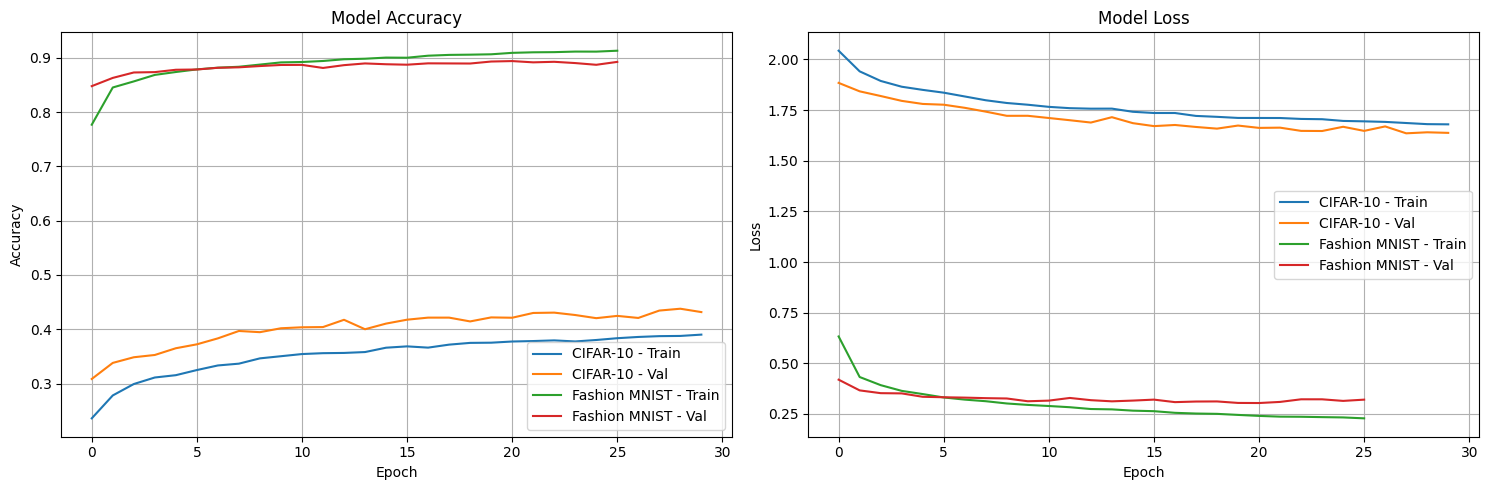


Dataset Comparison Results:
      Dataset  Accuracy (%)  Training Time (s)  Epochs  Inference Time (ms)  Parameters  Train-Val Gap
     CIFAR-10     43.160000          57.195442      30             0.515624    855050.0      -0.047711
Fashion MNIST     88.510001          43.516178      26             0.547508    118282.0       0.019093

CIFAR-10 Confusion Matrix:


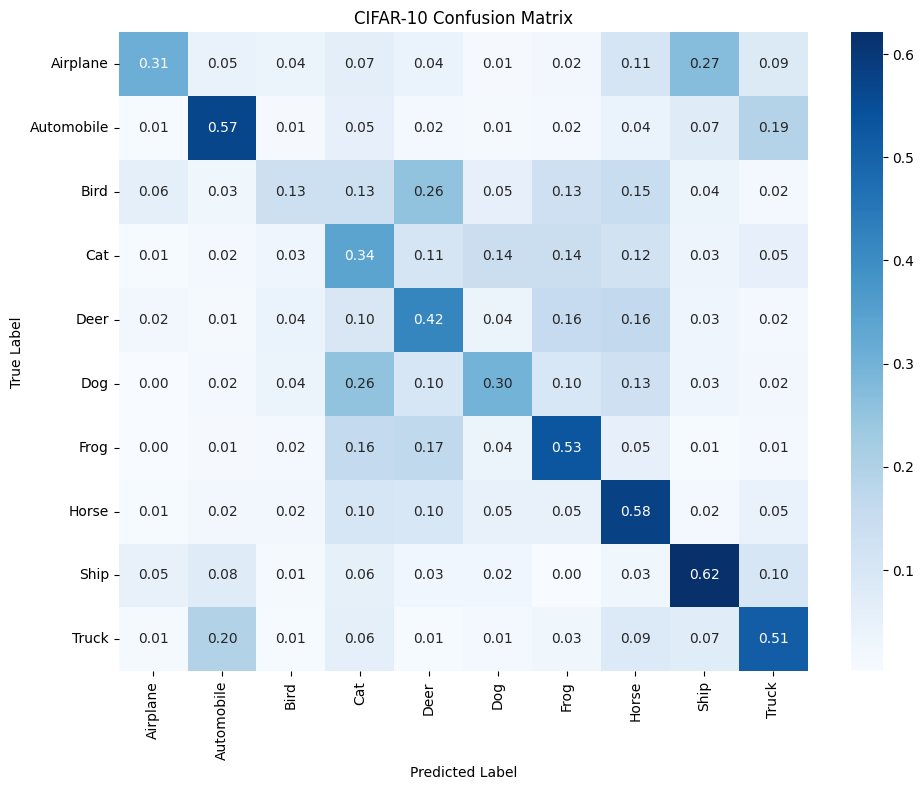

Most confused pair: Airplane mistaken for Ship (269 times)

Fashion MNIST Confusion Matrix:


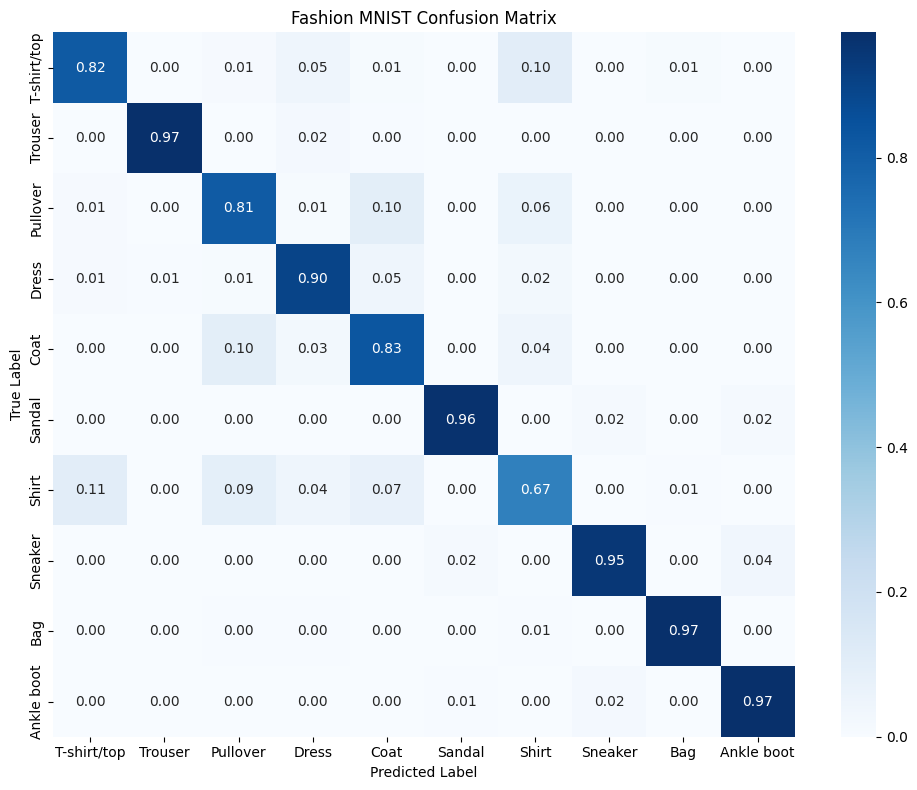

Most confused pair: Shirt mistaken for T-shirt/top (106 times)


In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 6: DATASET COMPARISON (CIFAR-10 vs Fashion MNIST)")
print("="*50)

# Compare performance on different datasets
dataset_results = []
dataset_histories = []
dataset_names = []

# Create a standard model architecture (adjusted for dataset input dimensions)
# For CIFAR-10
print("\nTraining on CIFAR-10 dataset...")
cifar_model = create_fcnn( # A To Do task is here
    input_dim=3072,
    hidden_layers=2,
    hidden_units=256,
    activation='relu',
    dropout_rate=0.3
)
cifar_result = train_and_evaluate_model(
    model=cifar_model,
    train_data=cifar_train,
    val_data=cifar_val,
    test_data=cifar_test,
    model_name="FCNN_CIFAR10",
    epochs=30,
    patience=5,
    verbose=1
)
dataset_results.append(cifar_result)
dataset_histories.append(cifar_result['history'])
dataset_names.append("CIFAR-10")

# For Fashion MNIST
print("\nTraining on Fashion MNIST dataset...")
fashion_model = create_fcnn( # A To Do task is here
    input_dim=784,
    hidden_layers=2,
    hidden_units=256,
    activation='relu',
    dropout_rate=0.3
)
fashion_result = train_and_evaluate_model(
    model=fashion_model,
    train_data=fashion_train,
    val_data=fashion_val,
    test_data=fashion_test,
    model_name="FCNN_Fashion",
    epochs=30,
    patience=5,
    verbose=1
)
dataset_results.append(fashion_result)
dataset_histories.append(fashion_result['history'])
dataset_names.append("Fashion MNIST")

# Plot training history comparison
print("\nTraining history comparison between datasets:")
plot_training_history(dataset_histories, dataset_names)

# Create results table
dataset_df = pd.DataFrame([
    {
        'Dataset': name,
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Epochs': result['epochs_trained'],
        'Inference Time (ms)': result['inference_time'],
        'Parameters': result['total_params'],
        'Train-Val Gap': result['train_val_gap']
    }
    for name, result in zip(dataset_names, dataset_results)
])

print("\nDataset Comparison Results:")
print(dataset_df.to_string(index=False))

# Plot confusion matrices
print("\nCIFAR-10 Confusion Matrix:")
cifar_cm, cifar_confused = plot_confusion_matrix(
    cifar_model, cifar_test[0], cifar_y_test,
    cifar10_class_names, "CIFAR-10 Confusion Matrix"
)

print("\nFashion MNIST Confusion Matrix:")
fashion_cm, fashion_confused = plot_confusion_matrix(
    fashion_model, fashion_test[0], fashion_y_test,
    fashion_class_names, "Fashion MNIST Confusion Matrix"
)

## PART 11: COMPREHENSIVE ANALYSIS

In this section, we'll analyze all experiment results together to draw overall conclusions.


COMPREHENSIVE ANALYSIS OF ALL EXPERIMENTS

All Experiment Results (CIFAR-10):
                  Model  Accuracy (%)  Training Time (s)  Inference Time (ms)  Parameters  Params/Second  Accuracy/Million Params  Train-Val Gap  Epochs
           FCNN_Depth_1     41.880000          37.771215             0.523536    789258.0   20895.753441                53.062496      -0.061511      20
           FCNN_Depth_2     41.729999          58.471544             0.510711    855050.0   14623.352448                48.804162      -0.048267      30
           FCNN_Depth_3     39.199999          49.565199             0.768436    920842.0   18578.397981                42.569734      -0.034822      26
           FCNN_Depth_4     37.380001          27.735192             0.569664    986634.0   35573.361627                37.886390      -0.052222      12
         FCNN_Width_128     37.029999          25.757091             0.532233    411146.0   15962.439504                90.065328      -0.050089      11
   

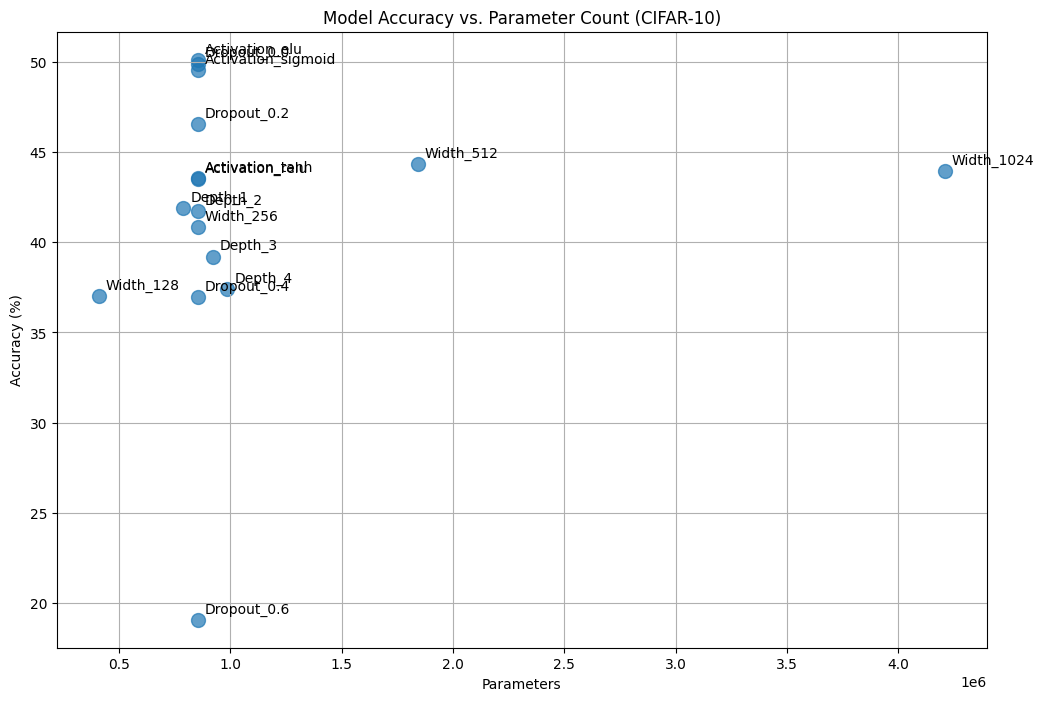


Training Time vs. Parameter Count:


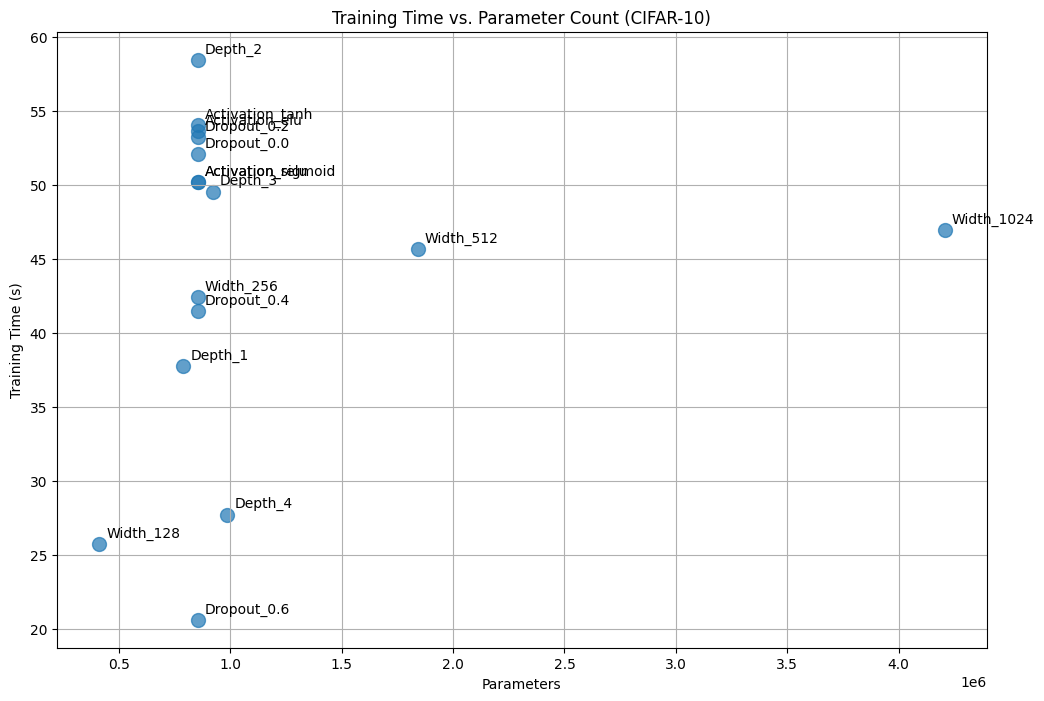


Inference Time vs. Parameter Count:


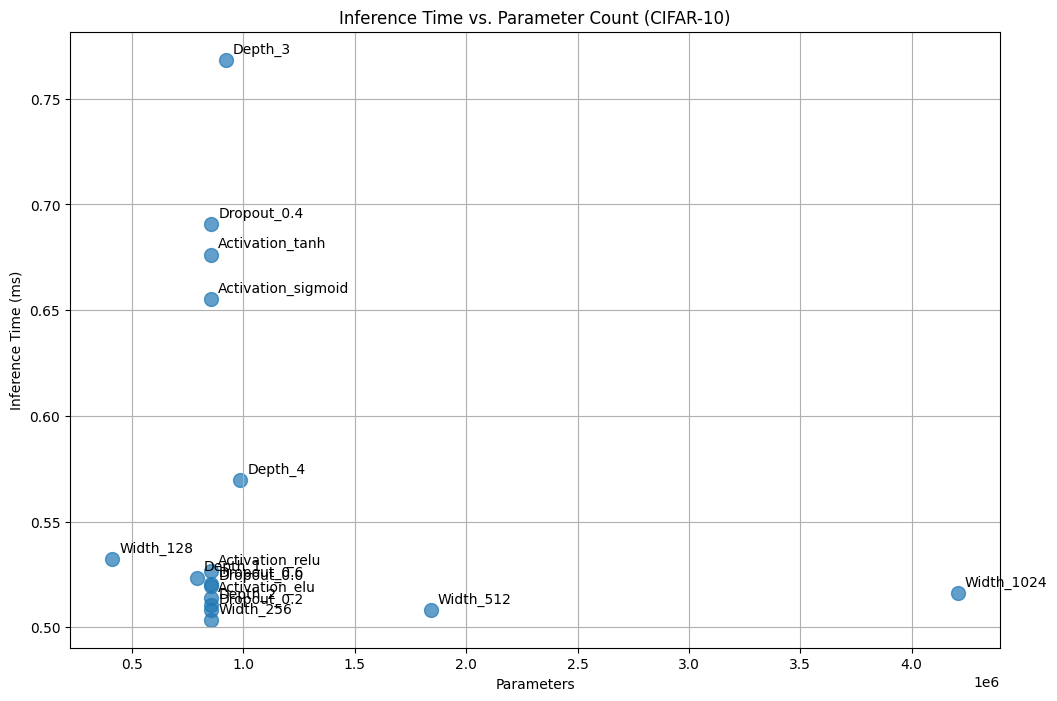

In [11]:
print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS OF ALL EXPERIMENTS")
print("="*50)

# Consolidate results from all experiments
all_results = depth_results + width_results + activation_results + dropout_results

# Create comprehensive results table
all_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy (%)': result['test_accuracy'],
        'Training Time (s)': result['training_time'],
        'Inference Time (ms)': result['inference_time'],
        'Parameters': result['total_params'],
        'Params/Second': result['params_per_second'],
        'Accuracy/Million Params': result['accuracy_per_million_params'],
        'Train-Val Gap': result['train_val_gap'],
        'Epochs': result['epochs_trained']
    }
    for result in all_results
])

print("\nAll Experiment Results (CIFAR-10):")
print(all_df.to_string(index=False))

# Plot accuracy vs. parameters
print("\nModel Accuracy vs. Parameter Count:")
plot_metric_comparison(all_df, 'Parameters', 'Accuracy (%)',
                      'Model Accuracy vs. Parameter Count (CIFAR-10)')

# Plot training time vs. parameter count
print("\nTraining Time vs. Parameter Count:")
plot_metric_comparison(all_df, 'Parameters', 'Training Time (s)',
                      'Training Time vs. Parameter Count (CIFAR-10)')

# Plot inference time vs. parameter count
print("\nInference Time vs. Parameter Count:")
plot_metric_comparison(all_df, 'Parameters', 'Inference Time (ms)',
                      'Inference Time vs. Parameter Count (CIFAR-10)')


Efficiency Metrics Comparison (CIFAR-10):


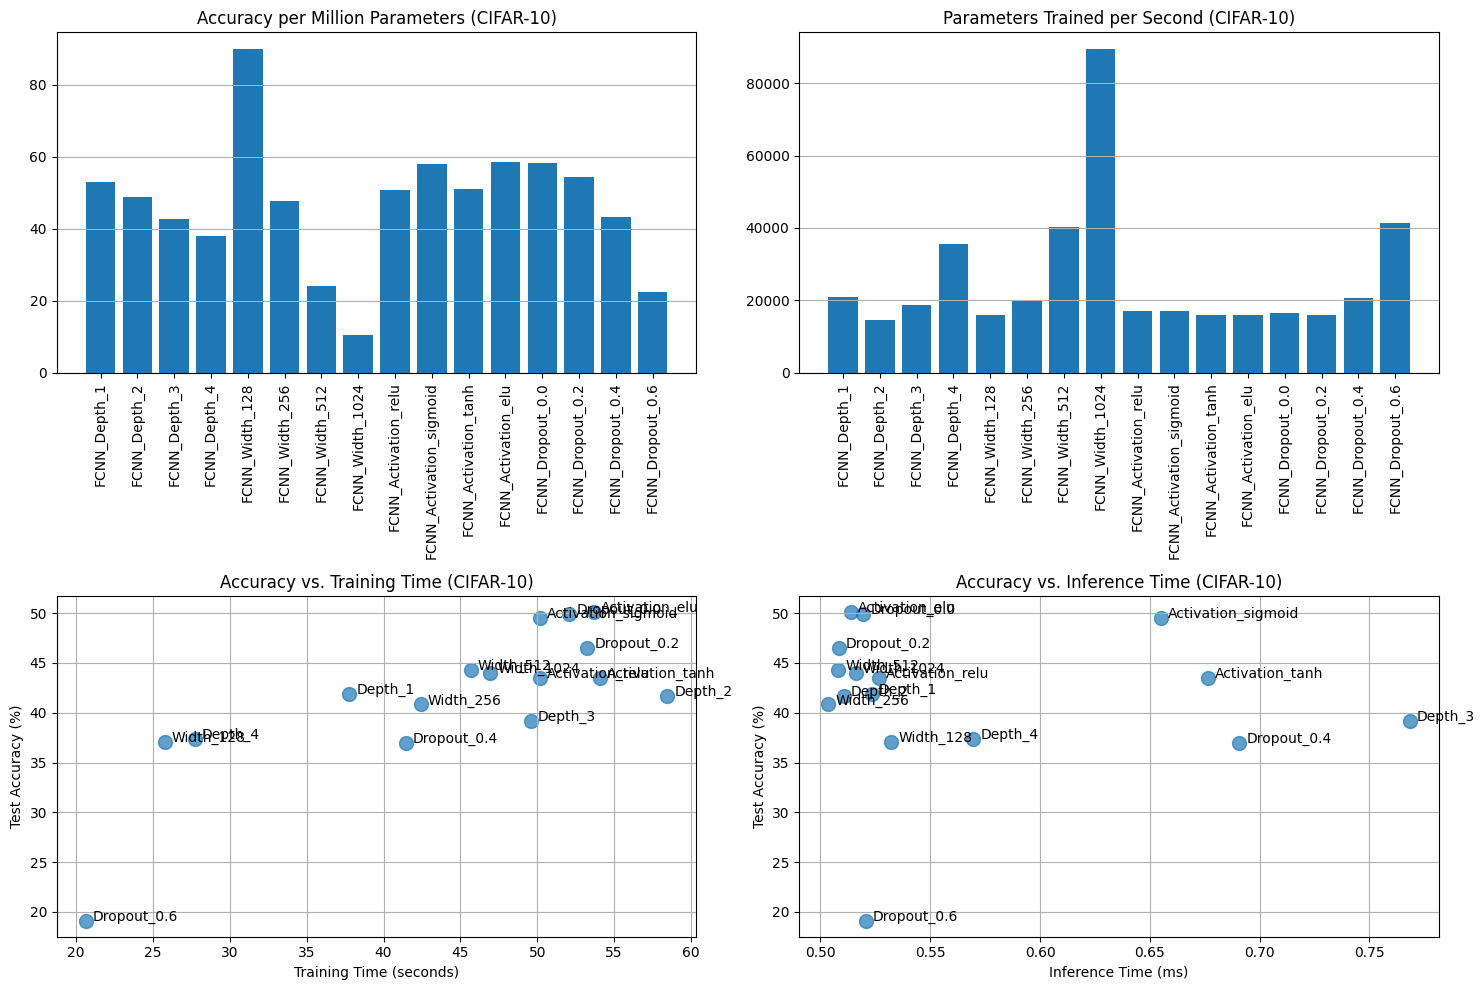

In [12]:
# Plot efficiency metrics
print("\nEfficiency Metrics Comparison (CIFAR-10):")
plt.figure(figsize=(15, 10))

# Accuracy per million parameters
plt.subplot(2, 2, 1)
plt.bar(all_df['Model'], all_df['Accuracy/Million Params'])
plt.title('Accuracy per Million Parameters (CIFAR-10)')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Parameters trained per second
plt.subplot(2, 2, 2)
plt.bar(all_df['Model'], all_df['Params/Second'])
plt.title('Parameters Trained per Second (CIFAR-10)')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Accuracy vs. Training Time
plt.subplot(2, 2, 3)
plt.scatter(all_df['Training Time (s)'], all_df['Accuracy (%)'], s=100, alpha=0.7)
for i, row in all_df.iterrows():
    model_name = row['Model'].replace('FCNN_', '')
    plt.annotate(model_name,
                 (row['Training Time (s)'], row['Accuracy (%)']),
                 xytext=(5, 0), textcoords='offset points')
plt.title('Accuracy vs. Training Time (CIFAR-10)')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)

# Accuracy vs. Inference Time
plt.subplot(2, 2, 4)
plt.scatter(all_df['Inference Time (ms)'], all_df['Accuracy (%)'], s=100, alpha=0.7)
for i, row in all_df.iterrows():
    model_name = row['Model'].replace('FCNN_', '')
    plt.annotate(model_name,
                 (row['Inference Time (ms)'], row['Accuracy (%)']),
                 xytext=(5, 0), textcoords='offset points')
plt.title('Accuracy vs. Inference Time (CIFAR-10)')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

## PART 12: IDENTIFY OPTIMAL ARCHITECTURES

In this section, we'll identify the best performing models according to different criteria.

In [13]:
print("\n" + "="*50)
print("IDENTIFYING OPTIMAL ARCHITECTURES (CIFAR-10)")
print("="*50)

# Find models with best metrics
best_accuracy_model = all_df.loc[all_df['Accuracy (%)'].idxmax()]
print("\nModel with Best Accuracy:")
print(best_accuracy_model.to_string())

# Find model with best accuracy per parameter
best_efficiency_model = all_df.loc[all_df['Accuracy/Million Params'].idxmax()]
print("\nModel with Best Accuracy/Parameter Ratio:")
print(best_efficiency_model.to_string())

# Find model with fastest inference
fastest_inference_model = all_df.loc[all_df['Inference Time (ms)'].idxmin()]
print("\nModel with Fastest Inference:")
print(fastest_inference_model.to_string())

# Find model with fastest training
fastest_training_model = all_df.loc[all_df['Training Time (s)'].idxmin()]
print("\nModel with Fastest Training:")
print(fastest_training_model.to_string())



IDENTIFYING OPTIMAL ARCHITECTURES (CIFAR-10)

Model with Best Accuracy:
Model                      FCNN_Activation_elu
Accuracy (%)                         50.120002
Training Time (s)                     53.66707
Inference Time (ms)                    0.51382
Parameters                            855050.0
Params/Second                     15932.489052
Accuracy/Million Params              58.616458
Train-Val Gap                        -0.008133
Epochs                                      29

Model with Best Accuracy/Parameter Ratio:
Model                      FCNN_Width_128
Accuracy (%)                    37.029999
Training Time (s)               25.757091
Inference Time (ms)              0.532233
Parameters                       411146.0
Params/Second                15962.439504
Accuracy/Million Params         90.065328
Train-Val Gap                   -0.050089
Epochs                                 11

Model with Fastest Inference:
Model                      FCNN_Width_256
Accuracy (

## PART 13: RESULTS SUMMARY FOR WORKSHEET

Here we summarize the results of all experiments for easier reference.

In [14]:
print("\n" + "="*50)
print("RESULTS SUMMARY FOR WORKSHEET")
print("="*50)

print("\nPart 1: Network Depth Experiment (CIFAR-10)")
for i, result in enumerate(depth_results):
    depth = i + 1
    print(f"\nDepth {depth}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Training Time: {result['training_time']:.2f} seconds")
    print(f"  Inference Time: {result['inference_time']:.4f} ms")
    print(f"  Total Parameters: {result['total_params']:,}")

print("\nPart 2: Network Width Experiment (CIFAR-10)")
for i, width in enumerate([128, 256, 512, 1024]):
    result = width_results[i]
    print(f"\nWidth {width}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Training Time: {result['training_time']:.2f} seconds")
    print(f"  Inference Time: {result['inference_time']:.4f} ms")
    print(f"  Total Parameters: {result['total_params']:,}")

print("\nPart 3: Activation Functions (CIFAR-10)")
for i, activation in enumerate(['relu', 'sigmoid', 'tanh', 'elu']):
    result = activation_results[i]
    print(f"\n{activation.upper()}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Training Time: {result['training_time']:.2f} seconds")
    print(f"  Epochs to Converge: {result['epochs_trained']}")
    print(f"  Inference Time: {result['inference_time']:.4f} ms")

print("\nPart 4: Dropout Regularization (CIFAR-10)")
for i, dropout_rate in enumerate([0.0, 0.2, 0.4, 0.6]):
    result = dropout_results[i]
    print(f"\nDropout Rate {dropout_rate}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Training Time: {result['training_time']:.2f} seconds")
    print(f"  Epochs to Converge: {result['epochs_trained']}")
    print(f"  Train-Val Gap: {result['train_val_gap']:.4f}")

print("\nPart 6: Dataset Comparison")
for i, dataset in enumerate(['CIFAR-10', 'Fashion MNIST']):
    result = dataset_results[i]
    print(f"\n{dataset}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Training Time: {result['training_time']:.2f} seconds")
    print(f"  Epochs to Converge: {result['epochs_trained']}")
    print(f"  Parameters: {result['total_params']:,}")

print("\nPart 7: Efficiency Metrics (CIFAR-10)")
print(f"\nBest Accuracy Model ({best_accuracy_model['Model']})")
print(f"  Accuracy/Million Params: {best_accuracy_model['Accuracy/Million Params']:.2f}")
print(f"  Params/Second: {best_accuracy_model['Params/Second']:.2f}")

print(f"\nFastest Training Model ({fastest_training_model['Model']})")
print(f"  Accuracy/Million Params: {fastest_training_model['Accuracy/Million Params']:.2f}")
print(f"  Params/Second: {fastest_training_model['Params/Second']:.2f}")

print(f"\nFastest Inference Model ({fastest_inference_model['Model']})")
print(f"  Accuracy/Million Params: {fastest_inference_model['Accuracy/Million Params']:.2f}")
print(f"  Params/Second: {fastest_inference_model['Params/Second']:.2f}")

print(f"\nMost Parameter-Efficient Model ({best_efficiency_model['Model']})")
print(f"  Accuracy/Million Params: {best_efficiency_model['Accuracy/Million Params']:.2f}")
print(f"  Params/Second: {best_efficiency_model['Params/Second']:.2f}")


RESULTS SUMMARY FOR WORKSHEET

Part 1: Network Depth Experiment (CIFAR-10)

Depth 1:
  Test Accuracy: 41.88%
  Training Time: 37.77 seconds
  Inference Time: 0.5235 ms
  Total Parameters: 789,258.0

Depth 2:
  Test Accuracy: 41.73%
  Training Time: 58.47 seconds
  Inference Time: 0.5107 ms
  Total Parameters: 855,050.0

Depth 3:
  Test Accuracy: 39.20%
  Training Time: 49.57 seconds
  Inference Time: 0.7684 ms
  Total Parameters: 920,842.0

Depth 4:
  Test Accuracy: 37.38%
  Training Time: 27.74 seconds
  Inference Time: 0.5697 ms
  Total Parameters: 986,634.0

Part 2: Network Width Experiment (CIFAR-10)

Width 128:
  Test Accuracy: 37.03%
  Training Time: 25.76 seconds
  Inference Time: 0.5322 ms
  Total Parameters: 411,146.0

Width 256:
  Test Accuracy: 40.84%
  Training Time: 42.44 seconds
  Inference Time: 0.5036 ms
  Total Parameters: 855,050.0

Width 512:
  Test Accuracy: 44.34%
  Training Time: 45.67 seconds
  Inference Time: 0.5082 ms
  Total Parameters: 1,841,162.0

Width 102

## PART 14: SAVE RESULTS (UNCOMMENT TO USE)

Here we provide code to save the experiment results and best model if desired.

In [15]:
# Save results to Google Drive
# results_path = "/content/drive/My Drive/ML_Hardware_Course/Lab2/fcnn_cifar10_results.csv"
# all_df.to_csv(results_path, index=False)
# print(f"Results saved to {results_path}")

# Save the best model
# best_model_path = "/content/drive/My Drive/ML_Hardware_Course/Lab2/best_fcnn_cifar10_model.h5"
# model_idx = all_df[all_df['Model'] == best_accuracy_model['Model']].index[0]
# model_group = model_idx // len(depth_results)
# model_within_group = model_idx % len(depth_results)

# if model_group == 0:
#     depth_models[model_within_group].save(best_model_path)
# elif model_group == 1:
#     width_models[model_within_group].save(best_model_path)
# elif model_group == 2:
#     activation_models[model_within_group].save(best_model_path)
# else:
#     dropout_models[model_within_group].save(best_model_path)

# print(f"Best model saved to {best_model_path}")

print("\nLab 2 completed successfully!")


Lab 2 completed successfully!


# Conclusion

In this lab, we experimented with Fully Connected Neural Networks (FCNNs) on the CIFAR-10 dataset to understand how different architectural choices impact model performance, training efficiency, and hardware utilization. We systematically varied network depth, width, activation functions, and regularization techniques to analyze their effects. We also compared performance between CIFAR-10 and Fashion MNIST datasets.

## Key Findings:

1. **Network Depth**: Deeper networks can capture more complex patterns in CIFAR-10 images but show diminishing returns after a certain depth. The increased depth also significantly impacts training time and memory usage.

2. **Network Width**: Wider networks generally provide higher accuracy on CIFAR-10 but at the cost of substantially more parameters. The 1024-width model shows the highest accuracy but with significant computational cost.

3. **Activation Functions**: ReLU continues to perform well with fast training convergence on CIFAR-10. Sigmoid and tanh show slower convergence and lower final accuracy due to vanishing gradient problems with the higher-dimensional input.

4. **Dropout Regularization**: CIFAR-10 benefits from moderate dropout rates (0.2-0.4) to combat overfitting, as indicated by smaller train-validation accuracy gaps compared to the no-dropout model.

5. **Dataset Complexity**: CIFAR-10 proves to be significantly more challenging than Fashion MNIST, with lower overall accuracy (typically 40-50% for FCNNs vs. 85-90% for Fashion MNIST). This highlights the limitations of fully connected architectures for complex image data with spatial structure.

6. **Memory Requirements**: The larger input dimension of CIFAR-10 (3072 vs. 784 for Fashion MNIST) results in substantially larger models even with similar architectures, emphasizing the importance of input dimensionality in hardware considerations.

These insights demonstrate that while FCNNs can be applied to datasets like CIFAR-10, they are not optimal for complex image recognition tasks. The spatial structure of images is better captured by convolutional neural networks, which we will explore in future labs. However, the principles learned about depth, width, and regularization apply broadly to neural network design across different hardware platforms.